In [1]:
import os

In [2]:
images_path = os.listdir('/kaggle/input/animefacedataset/images')

In [3]:
path = '/kaggle/input/animefacedataset/'

In [4]:
len(images_path)

63565

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64
batch_size = 128
stats = (0.5,0.5, 0.5), (0.5,0.5,0.5)

In [7]:
train_ds = ImageFolder(path,transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers = 3, pin_memory= True)

In [8]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [9]:
def denorm(img_tensors):
    return img_tensors* stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax= 64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8,).permute(1,2,0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images,nmax)
        break
        

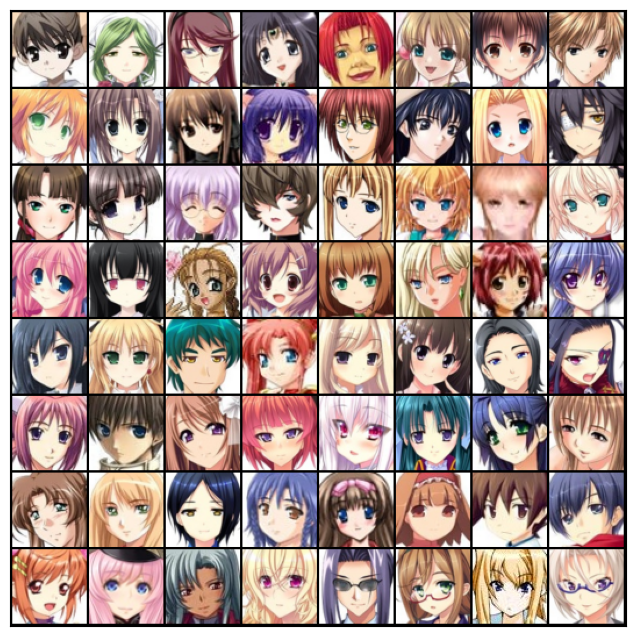

In [11]:
show_batch(train_dl)

# Accessing GPU

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator architecture

In [15]:
discriminator = nn.Sequential(  
            
    nn.Conv2d(3, 64,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(64,128, kernel_size=4, stride=2, padding=1, bias= False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 256,kernel_size=4, stride= 2, padding=1, bias= False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(256, 512, kernel_size=4, stride= 2, padding=1, bias= False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(512,1, kernel_size = 4, stride=1, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid()

    
)

In [16]:
discrimanator = to_device(discriminator, device)

# Generator

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias =False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias =False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias =False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias =False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    

)

torch.Size([128, 3, 64, 64])


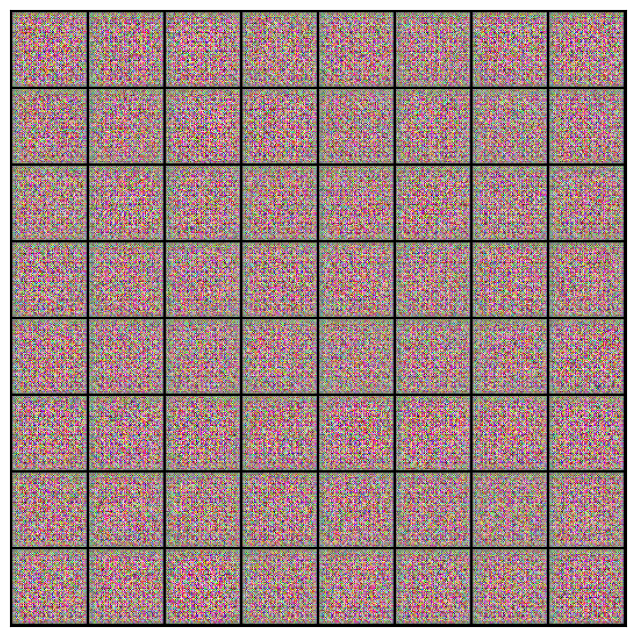

In [19]:
xb = torch.randn(batch_size, latent_size, 1,1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [20]:
generator =  to_device(generator, device)

# Discriminator Training

In [21]:
def train_discriminator(real_images, opt_d):
    
    opt_d.zero_grad()
    
    # Pass real image through dicriminator
    real_preds = discrimanator(real_images)
    real_targets = torch.ones(real_images.size(0),1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device= device)
    fake_images = generator(latent)
    
    # Pass fake images through discriminator
    
    fake_targets = torch.zeros(fake_images.size(0), 1, device= device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [22]:
def train_generator(opt_d):
    
    opt_d.zero_grad()
    
    # Generate fake images
    latent  = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)\
    
    # Try to fool the discriminator 
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device= device)
    loss =  F.binary_cross_entropy(preds, targets)
    # Update generator weights
    loss.backward()
    opt_d.step()
    
    return loss.item()

In [23]:
from torchvision.utils import save_image

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-image-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-image-0000.png


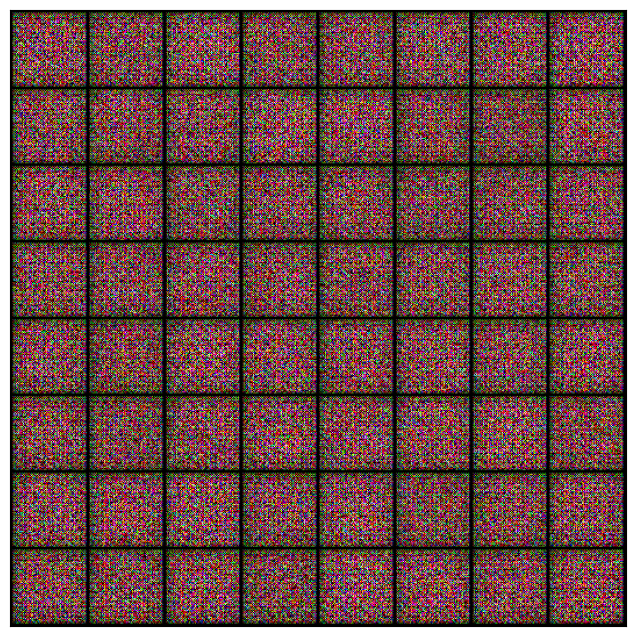

In [27]:
save_samples(0, fixed_latent)

In [28]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [29]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr= lr, betas = (0.5, 0.999))
    
    for epochs in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # train generator
            loss_g = train_generator(opt_g)
            
        
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print('Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}'.format(epochs+1,
                                                                                                             epochs, loss_g, loss_d, real_score, fake_score))
        
        save_samples(epochs+start_idx, fixed_latent, show= False)
        
    return losses_g, losses_d, real_scores, fake_scores

In [30]:
lr = 0.0002
epochs = 30

In [31]:
hisory = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/0], loss_g: 5.5537, loss_d: 0.2621, real_score: 0.9182, fake_score: 0.1469
Saving generated-image-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/1], loss_g: 4.7881, loss_d: 0.3804, real_score: 0.8390, fake_score: 0.1622
Saving generated-image-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/2], loss_g: 9.2992, loss_d: 0.8468, real_score: 0.9879, fake_score: 0.5081
Saving generated-image-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/3], loss_g: 4.4579, loss_d: 0.2747, real_score: 0.8596, fake_score: 0.0867
Saving generated-image-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/4], loss_g: 8.8966, loss_d: 0.2600, real_score: 0.9768, fake_score: 0.1944
Saving generated-image-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/5], loss_g: 4.7446, loss_d: 0.1120, real_score: 0.9452, fake_score: 0.0479
Saving generated-image-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/6], loss_g: 9.3383, loss_d: 0.3749, real_score: 0.9747, fake_score: 0.2700
Saving generated-image-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/7], loss_g: 6.9822, loss_d: 0.2217, real_score: 0.9262, fake_score: 0.0990
Saving generated-image-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/8], loss_g: 7.7440, loss_d: 0.1333, real_score: 0.9834, fake_score: 0.1052
Saving generated-image-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/9], loss_g: 17.4548, loss_d: 0.3771, real_score: 0.9904, fake_score: 0.2259
Saving generated-image-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/10], loss_g: 9.9512, loss_d: 0.2613, real_score: 0.9732, fake_score: 0.1839
Saving generated-image-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/11], loss_g: 6.4075, loss_d: 0.0865, real_score: 0.9465, fake_score: 0.0093
Saving generated-image-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/12], loss_g: 12.7682, loss_d: 0.1915, real_score: 0.8915, fake_score: 0.0000
Saving generated-image-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/13], loss_g: 6.0308, loss_d: 0.0491, real_score: 0.9771, fake_score: 0.0154
Saving generated-image-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/14], loss_g: 6.5699, loss_d: 0.0689, real_score: 0.9665, fake_score: 0.0300
Saving generated-image-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/15], loss_g: 8.7293, loss_d: 0.1237, real_score: 0.9925, fake_score: 0.1039
Saving generated-image-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/16], loss_g: 5.7530, loss_d: 0.0600, real_score: 0.9715, fake_score: 0.0282
Saving generated-image-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/17], loss_g: 6.0733, loss_d: 0.0783, real_score: 0.9710, fake_score: 0.0445
Saving generated-image-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/18], loss_g: 17.6476, loss_d: 0.2406, real_score: 0.9643, fake_score: 0.1022
Saving generated-image-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/19], loss_g: 5.8594, loss_d: 0.0412, real_score: 0.9708, fake_score: 0.0092
Saving generated-image-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/20], loss_g: 8.3869, loss_d: 0.0733, real_score: 0.9765, fake_score: 0.0434
Saving generated-image-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/21], loss_g: 8.7916, loss_d: 0.1076, real_score: 0.9854, fake_score: 0.0838
Saving generated-image-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/22], loss_g: 8.2647, loss_d: 0.0470, real_score: 0.9634, fake_score: 0.0037
Saving generated-image-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/23], loss_g: 5.3762, loss_d: 0.0437, real_score: 0.9752, fake_score: 0.0146
Saving generated-image-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/24], loss_g: 3.8905, loss_d: 0.1209, real_score: 0.9336, fake_score: 0.0122
Saving generated-image-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/25], loss_g: 5.6743, loss_d: 0.0589, real_score: 0.9729, fake_score: 0.0283
Saving generated-image-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/26], loss_g: 10.7569, loss_d: 0.1598, real_score: 0.9772, fake_score: 0.1171
Saving generated-image-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/27], loss_g: 6.4378, loss_d: 0.0755, real_score: 0.9840, fake_score: 0.0511
Saving generated-image-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/28], loss_g: 6.8069, loss_d: 0.0872, real_score: 0.9536, fake_score: 0.0185
Saving generated-image-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/29], loss_g: 8.4582, loss_d: 0.0044, real_score: 0.9964, fake_score: 0.0007
Saving generated-image-0030.png


In [32]:
losses_g, losses_d, real_scores, fake_scores = hisory

In [33]:
torch.save(generator.state_dict(),'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [34]:
from IPython.display import Image

In [39]:
!pwd 

/kaggle/working


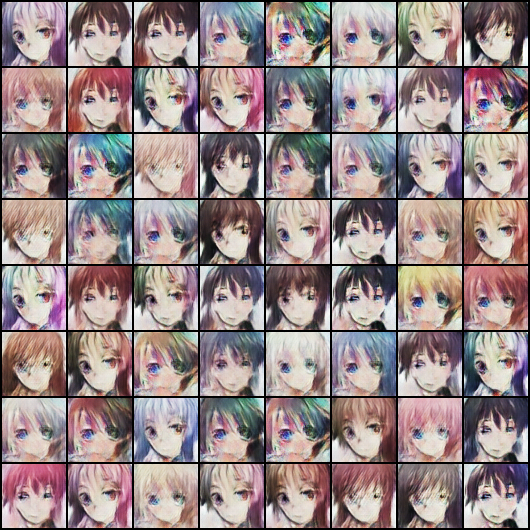

In [44]:
Image('./generated/generated-image-0025.png')